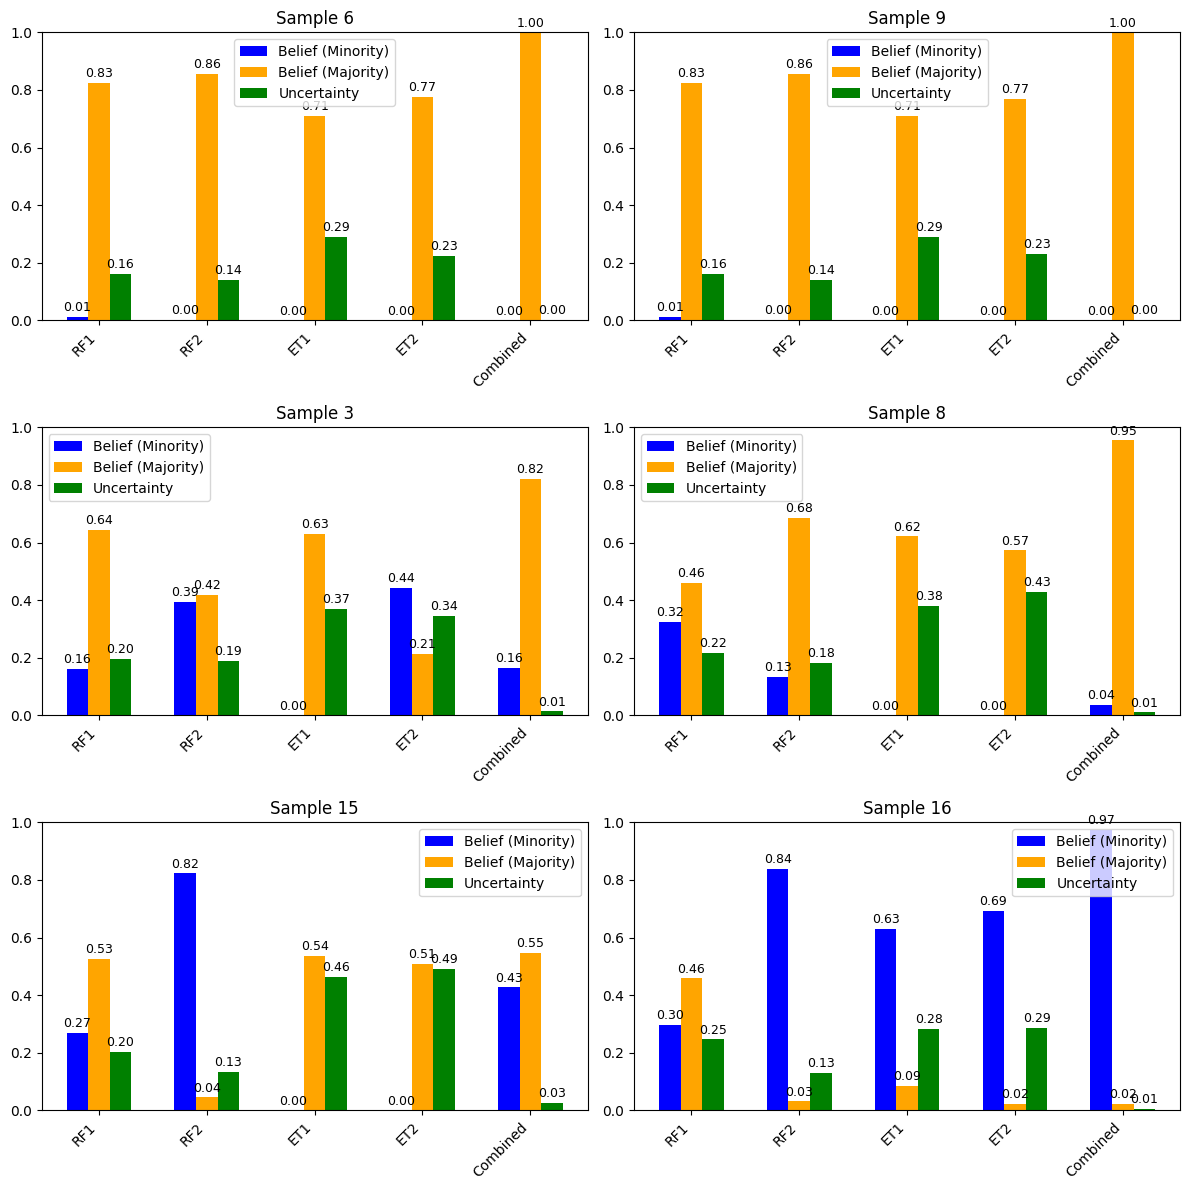

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from func_utils import KL
# 生成均衡数据集
X, y = make_moons(n_samples=40, noise=0.3, random_state=36)

# 对类别 1 进行下采样
minority_class_samples = X[y == 1]
majority_class_samples = X[y == 0]

# 保留所有的多数类样本，减少少数类样本至 10 个
minority_class_samples = minority_class_samples[:10]

# 合并数据，生成不均衡数据集
X = np.vstack([majority_class_samples, minority_class_samples])
y = np.hstack([np.zeros(len(majority_class_samples)), np.ones(len(minority_class_samples))])

# 特殊点的索引
special_indices = [6, 9, 3, 8, 15, 16]

# 创建 4 个分类器
clf1 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf3 = ExtraTreesClassifier(n_estimators=50, n_jobs=-1)
clf4 = ExtraTreesClassifier(n_estimators=50, n_jobs=-1)

# 独立对每个分类器进行随机下采样
rus = RandomUnderSampler()
X_resampled_1, y_resampled_1 = rus.fit_resample(X, y)
X_resampled_2, y_resampled_2 = rus.fit_resample(X, y)
X_resampled_3, y_resampled_3 = rus.fit_resample(X, y)
X_resampled_4, y_resampled_4 = rus.fit_resample(X, y)

# 使用下采样后的数据训练模型
clf1.fit(X_resampled_1, y_resampled_1)
clf2.fit(X_resampled_2, y_resampled_2)
clf3.fit(X_resampled_3, y_resampled_3)
clf4.fit(X_resampled_4, y_resampled_4)

# 计算特殊点在每个分类器中的叶子节点证据
results = []
for model_name, model in zip(['RF1', 'RF2', 'ET1', 'ET2'], [clf1, clf2, clf3, clf4]):
    for sample_idx in special_indices:
        sample = X[sample_idx].reshape(1, -1)
        total_samples_per_class = np.zeros(model.n_classes_)
        
        # 遍历基分类器
        for tree in model.estimators_:
            leaf_index = tree.apply(sample)[0]
            tree_structure = tree.tree_
            samples_per_class = tree_structure.value[leaf_index, 0]
            total_samples_per_class += samples_per_class

        # 保存结果
        results.append({
            'Model': model_name,
            'Sample Index': sample_idx,
            'Class 0 Evidence': total_samples_per_class[0],
            'Class 1 Evidence': total_samples_per_class[1]
        })

# 定义参数 W
W = 25

# 计算单独观点
opinions = {}
for sample_idx in special_indices:
    sample_opinions = []
    for model_name in ['RF1', 'RF2', 'ET1', 'ET2']:
        result = next(r for r in results if r['Model'] == model_name and r['Sample Index'] == sample_idx)
        E_min = result['Class 1 Evidence']
        E_maj = result['Class 0 Evidence']
        denominator = E_min + E_maj + 2 * W
        belief_min = E_min / denominator
        belief_maj = E_maj / denominator
        uncertainty = 2 * W / denominator
        sample_opinions.append((belief_min, belief_maj, uncertainty))
    opinions[sample_idx] = sample_opinions

# 链式合并观点
def combine_opinions(opinion_1, opinion_2):
    b_i, d_i, u_i = opinion_1
    b_j, d_j, u_j = opinion_2
    C = b_i * d_j + b_j * d_i
    b_combined = (b_i * b_j + b_i * u_j + b_j * u_i) / (1 - C)
    d_combined = (d_i * d_j + d_i * u_j + d_j * u_i) / (1 - C)
    u_combined = (u_i * u_j) / (1 - C)
    return b_combined, d_combined, u_combined

combined_opinions = {}
for sample_idx, sample_opinions in opinions.items():
    combined_opinion = sample_opinions[0]
    for opinion in sample_opinions[1:]:
        combined_opinion = combine_opinions(combined_opinion, opinion)
    combined_opinions[sample_idx] = combined_opinion

# 可视化
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=100)
axes = axes.flatten()  # 将轴展平以便索引

for i, sample_idx in enumerate(special_indices):
    single_opinions = opinions[sample_idx]
    combined = combined_opinions[sample_idx]
    
    x = ['RF1', 'RF2', 'ET1', 'ET2', 'Combined']
    beliefs_minority = [o[0] for o in single_opinions] + [combined[0]]
    beliefs_majority = [o[1] for o in single_opinions] + [combined[1]]
    uncertainties = [o[2] for o in single_opinions] + [combined[2]]
    
    ax = axes[i]
    ax.set_ylim(0, 1)  # 设置 y 轴上限为 1
    bar_width = 0.2
    
    # 绘制柱状图
    bars_min = ax.bar(np.arange(len(x)) - bar_width, beliefs_minority, bar_width, label='Belief (Minority)', color='blue')
    bars_maj = ax.bar(np.arange(len(x)), beliefs_majority, bar_width, label='Belief (Majority)', color='orange')
    bars_unc = ax.bar(np.arange(len(x)) + bar_width, uncertainties, bar_width, label='Uncertainty', color='green')
    
    # 添加数值标注
    for bar in bars_min:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_maj:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_unc:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    
    # 设置 x 轴标签和标题
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_title(f"Sample {sample_idx}")
    ax.legend()

# 隐藏多余的子图
for i in range(len(special_indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


C:\Users\10928\AppData\Local\Temp\ipykernel_224576\1126765928.py:17: RuntimeWarning: invalid value encountered in add
  kl = np.sum((alpha - beta) * (dg1 - dg0), axis=1, keepdims=True) + lnB + lnB_uni


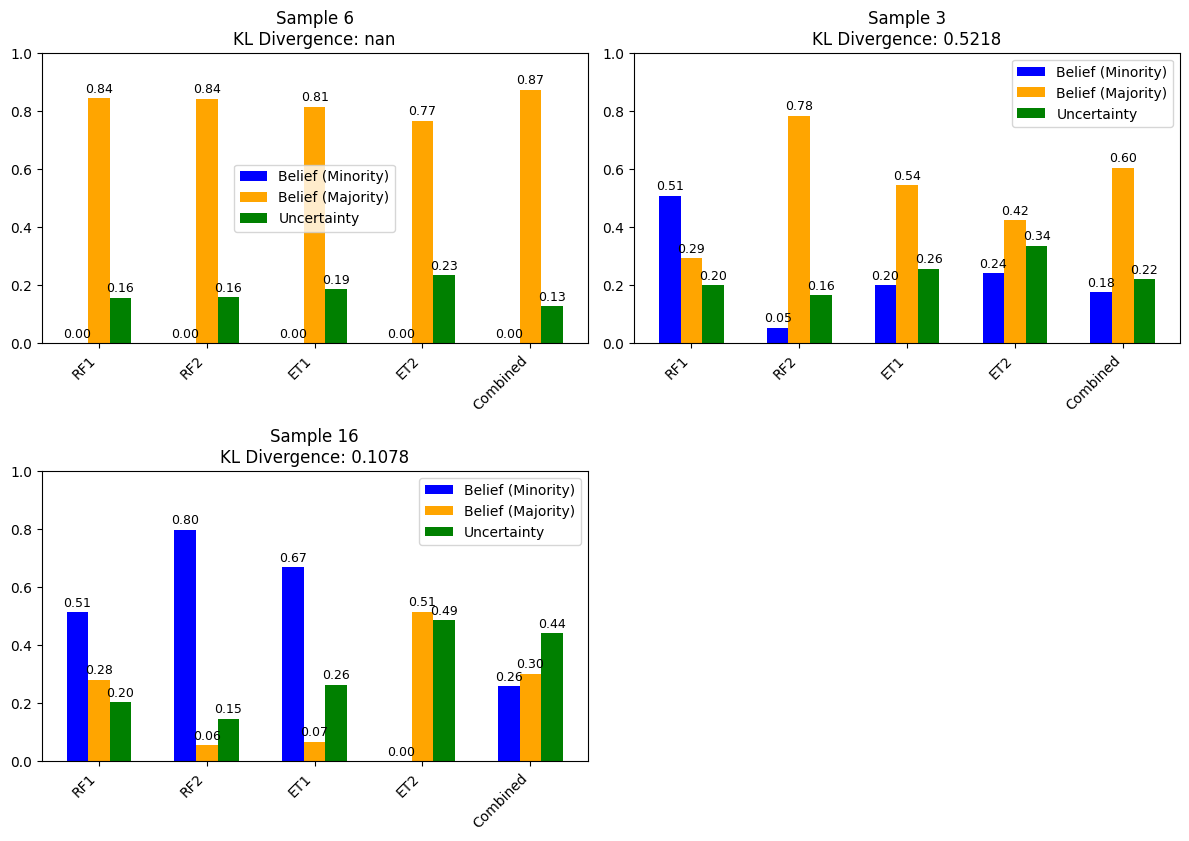

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.special import gammaln, digamma

# 定义 KL 散度函数
def KL(alpha, c):
    beta = np.ones((1, c))
    S_alpha = np.sum(alpha, axis=1, keepdims=True)
    S_beta = np.sum(beta, axis=1, keepdims=True)
    lnB = gammaln(S_alpha) - np.sum(gammaln(alpha), axis=1, keepdims=True)
    lnB_uni = np.sum(gammaln(beta), axis=1, keepdims=True) - gammaln(S_beta)
    dg0 = digamma(S_alpha)
    dg1 = digamma(alpha)
    kl = np.sum((alpha - beta) * (dg1 - dg0), axis=1, keepdims=True) + lnB + lnB_uni
    return kl

# 生成数据集
X, y = make_moons(n_samples=40, noise=0.3, random_state=36)
minority_class_samples = X[y == 1]
majority_class_samples = X[y == 0]
minority_class_samples = minority_class_samples[:10]
X = np.vstack([majority_class_samples, minority_class_samples])
y = np.hstack([np.zeros(len(majority_class_samples)), np.ones(len(minority_class_samples))])
special_indices = [6, 3, 16]

# 创建分类器
clf1 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf3 = ExtraTreesClassifier(n_estimators=50, n_jobs=-1)
clf4 = ExtraTreesClassifier(n_estimators=50, n_jobs=-1)

# 下采样
rus = RandomUnderSampler()
X_resampled_1, y_resampled_1 = rus.fit_resample(X, y)
X_resampled_2, y_resampled_2 = rus.fit_resample(X, y)
X_resampled_3, y_resampled_3 = rus.fit_resample(X, y)
X_resampled_4, y_resampled_4 = rus.fit_resample(X, y)

# 训练分类器
clf1.fit(X_resampled_1, y_resampled_1)
clf2.fit(X_resampled_2, y_resampled_2)
clf3.fit(X_resampled_3, y_resampled_3)
clf4.fit(X_resampled_4, y_resampled_4)

results = []
for model_name, model in zip(['RF1', 'RF2', 'ET1', 'ET2'], [clf1, clf2, clf3, clf4]):
    for sample_idx in special_indices:
        sample = X[sample_idx].reshape(1, -1)
        total_samples_per_class = np.zeros(model.n_classes_)
        for tree in model.estimators_:
            leaf_index = tree.apply(sample)[0]
            tree_structure = tree.tree_
            samples_per_class = tree_structure.value[leaf_index, 0]
            total_samples_per_class += samples_per_class
        results.append({
            'Model': model_name,
            'Sample Index': sample_idx,
            'Class 0 Evidence': total_samples_per_class[0],
            'Class 1 Evidence': total_samples_per_class[1]
        })

W = 25
opinions = {}
for sample_idx in special_indices:
    sample_opinions = []
    for model_name in ['RF1', 'RF2', 'ET1', 'ET2']:
        result = next(r for r in results if r['Model'] == model_name and r['Sample Index'] == sample_idx)
        E_min = result['Class 1 Evidence']
        E_maj = result['Class 0 Evidence']
        denominator = E_min + E_maj + 2 * W
        belief_min = E_min / denominator
        belief_maj = E_maj / denominator
        uncertainty = 2 * W / denominator
        sample_opinions.append((belief_min, belief_maj, uncertainty))
    opinions[sample_idx] = sample_opinions

def combine_opinions(opinion_1, opinion_2):
    b_i, d_i, u_i = opinion_1
    b_j, d_j, u_j = opinion_2
    C = b_i * d_j + b_j * d_i
    b_combined = (b_i * b_j + b_i * u_j + b_j * u_i) / (1 - C)
    d_combined = (d_i * d_j + d_i * u_j + d_j * u_i) / (1 - C)
    u_combined = (u_i * u_j) / (1 - C)
    return b_combined, d_combined, u_combined

import numpy as np

def combine_opinions2(opinion_1, opinion_2):
    """
    基于图中 DS 理论融合公式实现的融合方法
    :param opinion_1: 第一个观点向量 (belief, disbelief, uncertainty)
    :param opinion_2: 第二个观点向量 (belief, disbelief, uncertainty)
    :return: 融合后的观点向量
    """
    b_i, d_i, u_i = opinion_1
    b_j, d_j, u_j = opinion_2

    # 转换为 numpy 数组以方便逐元素计算
    e1 = np.array([b_i, d_i, u_i])
    e2 = np.array([b_j, d_j, u_j])

    # 按逐元素相乘计算 e1 ∘ e2
    elementwise_product = e1 * e2

    # 计算归一化系数 C
    C = np.sum(elementwise_product)

    # DS 理论融合公式
    fused_opinion = (1 / C) * elementwise_product + (e1 + e2)

    # 确保融合结果是一个有效的观点向量
    fused_opinion /= np.sum(fused_opinion)

    return tuple(fused_opinion)

combined_opinions = {}
for sample_idx, sample_opinions in opinions.items():
    combined_opinion = sample_opinions[0]
    for opinion in sample_opinions[1:]:
        combined_opinion = combine_opinions2(combined_opinion, opinion)
    combined_opinions[sample_idx] = combined_opinion

# 计算 KL 散度
c = 2
kl_divergences = {}
for sample_idx, combined_opinion in combined_opinions.items():
    belief_minority, belief_majority, uncertainty = combined_opinion
    alpha = np.array([[belief_minority, belief_majority]]) * (1 / uncertainty)
    kl_div = KL(alpha, c)
    kl_divergences[sample_idx] = kl_div[0][0]

# 可视化
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=100)
axes = axes.flatten()

for i, sample_idx in enumerate(special_indices):
    single_opinions = opinions[sample_idx]
    combined = combined_opinions[sample_idx]
    x = ['RF1', 'RF2', 'ET1', 'ET2', 'Combined']
    beliefs_minority = [o[0] for o in single_opinions] + [combined[0]]
    beliefs_majority = [o[1] for o in single_opinions] + [combined[1]]
    uncertainties = [o[2] for o in single_opinions] + [combined[2]]
    
    ax = axes[i]
    ax.set_ylim(0, 1)
    bar_width = 0.2
    bars_min = ax.bar(np.arange(len(x)) - bar_width, beliefs_minority, bar_width, label='Belief (Minority)', color='blue')
    bars_maj = ax.bar(np.arange(len(x)), beliefs_majority, bar_width, label='Belief (Majority)', color='orange')
    bars_unc = ax.bar(np.arange(len(x)) + bar_width, uncertainties, bar_width, label='Uncertainty', color='green')
    
    for bar in bars_min:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_maj:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_unc:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_title(f"Sample {sample_idx}\nKL Divergence: {kl_divergences[sample_idx]:.4f}")
    ax.legend()

# 删除多余子图
for i in range(len(special_indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Sample 6:
  Individual Beta Distributions and Opinions:
    RF1: alpha = 25.0000, beta = 361.0000, opinion = (b = 0.0000, d = 0.8705, u = 0.1295)
    RF2: alpha = 25.0000, beta = 329.0000, opinion = (b = 0.0000, d = 0.8588, u = 0.1412)
    ET1: alpha = 25.0000, beta = 170.0000, opinion = (b = 0.0000, d = 0.7436, u = 0.2564)
    ET2: alpha = 25.0000, beta = 215.0000, opinion = (b = 0.0000, d = 0.7917, u = 0.2083)
  Combined Beta Distribution: alpha = 25.0000, beta = 373.3697, opinion = (b = 0.0000, d = 0.8745, u = 0.1255)
Sample 3:
  Individual Beta Distributions and Opinions:
    RF1: alpha = 109.0000, beta = 178.0000, opinion = (b = 0.2927, d = 0.5331, u = 0.1742)
    RF2: alpha = 90.0000, beta = 207.0000, opinion = (b = 0.2189, d = 0.6128, u = 0.1684)
    ET1: alpha = 25.0000, beta = 110.0000, opinion = (b = 0.0000, d = 0.6296, u = 0.3704)
    ET2: alpha = 88.0000, beta = 84.0000, opinion = (b = 0.3663, d = 0.3430, u = 0.2907)
  Combined Beta Distribution: alpha = 63.4685, beta = 158

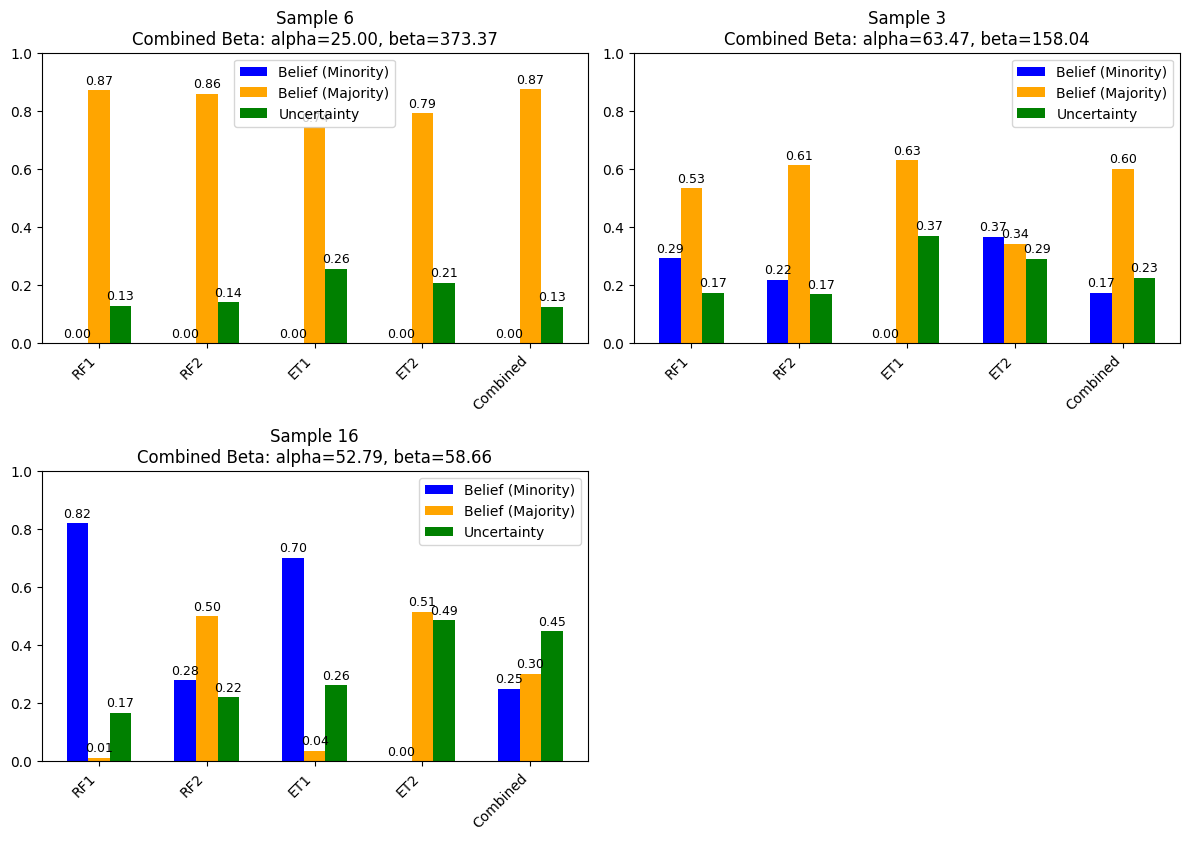

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.special import gammaln, digamma

# 定义 KL 散度函数
def KL(alpha, c):
    beta = np.ones((1, c))
    S_alpha = np.sum(alpha, axis=1, keepdims=True)
    S_beta = np.sum(beta, axis=1, keepdims=True)
    lnB = gammaln(S_alpha) - np.sum(gammaln(alpha), axis=1, keepdims=True)
    lnB_uni = np.sum(gammaln(beta), axis=1, keepdims=True) - gammaln(S_beta)
    dg0 = digamma(S_alpha)
    dg1 = digamma(alpha)
    kl = np.sum((alpha - beta) * (dg1 - dg0), axis=1, keepdims=True) + lnB + lnB_uni
    return kl

# 定义观点合并函数
def combine_opinions2(opinion_1, opinion_2):
    b_i, d_i, u_i = opinion_1
    b_j, d_j, u_j = opinion_2

    e1 = np.array([b_i, d_i, u_i])
    e2 = np.array([b_j, d_j, u_j])

    elementwise_product = e1 * e2
    C = np.sum(elementwise_product)

    fused_opinion = (1 / C) * elementwise_product + (e1 + e2)
    fused_opinion /= np.sum(fused_opinion)

    return tuple(fused_opinion)

# 生成数据集
X, y = make_moons(n_samples=40, noise=0.3, random_state=36)
minority_class_samples = X[y == 1]
majority_class_samples = X[y == 0]
minority_class_samples = minority_class_samples[:10]
X = np.vstack([majority_class_samples, minority_class_samples])
y = np.hstack([np.zeros(len(majority_class_samples)), np.ones(len(minority_class_samples))])
special_indices = [6, 3, 16]

# 创建分类器
clf1 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf3 = ExtraTreesClassifier(n_estimators=50, n_jobs=-1)
clf4 = ExtraTreesClassifier(n_estimators=50, n_jobs=-1)

# 下采样
rus = RandomUnderSampler()
X_resampled_1, y_resampled_1 = rus.fit_resample(X, y)
X_resampled_2, y_resampled_2 = rus.fit_resample(X, y)
X_resampled_3, y_resampled_3 = rus.fit_resample(X, y)
X_resampled_4, y_resampled_4 = rus.fit_resample(X, y)

# 训练分类器
clf1.fit(X_resampled_1, y_resampled_1)
clf2.fit(X_resampled_2, y_resampled_2)
clf3.fit(X_resampled_3, y_resampled_3)
clf4.fit(X_resampled_4, y_resampled_4)

# 收集分类器的预测证据
results = []
for model_name, model in zip(['RF1', 'RF2', 'ET1', 'ET2'], [clf1, clf2, clf3, clf4]):
    for sample_idx in special_indices:
        sample = X[sample_idx].reshape(1, -1)
        total_samples_per_class = np.zeros(model.n_classes_)
        for tree in model.estimators_:
            leaf_index = tree.apply(sample)[0]
            tree_structure = tree.tree_
            samples_per_class = tree_structure.value[leaf_index, 0]
            total_samples_per_class += samples_per_class
        results.append({
            'Model': model_name,
            'Sample Index': sample_idx,
            'Class 0 Evidence': total_samples_per_class[0],
            'Class 1 Evidence': total_samples_per_class[1]
        })

W = 25  # 权重
opinions = {}
for sample_idx in special_indices:
    sample_opinions = []
    for model_name in ['RF1', 'RF2', 'ET1', 'ET2']:
        result = next(r for r in results if r['Model'] == model_name and r['Sample Index'] == sample_idx)
        E_min = result['Class 1 Evidence']
        E_maj = result['Class 0 Evidence']
        denominator = E_min + E_maj + 2 * W
        belief_min = E_min / denominator
        belief_maj = E_maj / denominator
        uncertainty = 2 * W / denominator
        sample_opinions.append((belief_min, belief_maj, uncertainty))
    opinions[sample_idx] = sample_opinions

# 合并观点
combined_opinions = {}
for sample_idx, sample_opinions in opinions.items():
    combined_opinion = sample_opinions[0]
    for opinion in sample_opinions[1:]:
        combined_opinion = combine_opinions2(combined_opinion, opinion)
    combined_opinions[sample_idx] = combined_opinion

# 定义 Beta 分布参数字典
beta_distributions = {}
combined_beta_distributions = {}

# 单个观点的 Beta 分布计算
for sample_idx in special_indices:
    sample_beta_distributions = []
    for model_name in ['RF1', 'RF2', 'ET1', 'ET2']:
        result = next(r for r in results if r['Model'] == model_name and r['Sample Index'] == sample_idx)
        E_min = result['Class 1 Evidence']
        E_maj = result['Class 0 Evidence']
        alpha = E_min + W
        beta = E_maj + W
        sample_beta_distributions.append((alpha, beta))
    beta_distributions[sample_idx] = sample_beta_distributions

# 综合观点的 Beta 分布计算
for sample_idx, combined_opinion in combined_opinions.items():
    b_s, d_s, u_s = combined_opinion
    alpha_s = (b_s * 2 * W) / u_s + W
    beta_s = (d_s * 2 * W) / u_s + W
    combined_beta_distributions[sample_idx] = (alpha_s, beta_s)

# 打印 Beta 分布参数和对应的观点
for sample_idx in special_indices:
    print(f"Sample {sample_idx}:")
    print("  Individual Beta Distributions and Opinions:")
    for model_name, (alpha, beta), opinion in zip(['RF1', 'RF2', 'ET1', 'ET2'], beta_distributions[sample_idx], opinions[sample_idx]):
        belief_minority, belief_majority, uncertainty = opinion
        print(f"    {model_name}: alpha = {alpha:.4f}, beta = {beta:.4f}, opinion = (b = {belief_minority:.4f}, d = {belief_majority:.4f}, u = {uncertainty:.4f})")
    alpha_combined, beta_combined = combined_beta_distributions[sample_idx]
    b_combined, d_combined, u_combined = combined_opinions[sample_idx]
    print(f"  Combined Beta Distribution: alpha = {alpha_combined:.4f}, beta = {beta_combined:.4f}, opinion = (b = {b_combined:.4f}, d = {d_combined:.4f}, u = {u_combined:.4f})")

# 可视化
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=100)
axes = axes.flatten()

for i, sample_idx in enumerate(special_indices):
    single_opinions = opinions[sample_idx]
    combined = combined_opinions[sample_idx]
    x = ['RF1', 'RF2', 'ET1', 'ET2', 'Combined']
    beliefs_minority = [o[0] for o in single_opinions] + [combined[0]]
    beliefs_majority = [o[1] for o in single_opinions] + [combined[1]]
    uncertainties = [o[2] for o in single_opinions] + [combined[2]]
    
    ax = axes[i]
    ax.set_ylim(0, 1)
    bar_width = 0.2
    bars_min = ax.bar(np.arange(len(x)) - bar_width, beliefs_minority, bar_width, label='Belief (Minority)', color='blue')
    bars_maj = ax.bar(np.arange(len(x)), beliefs_majority, bar_width, label='Belief (Majority)', color='orange')
    bars_unc = ax.bar(np.arange(len(x)) + bar_width, uncertainties, bar_width, label='Uncertainty', color='green')
    
    for bar in bars_min:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_maj:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_unc:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_title(f"Sample {sample_idx}\nCombined Beta: alpha={combined_beta_distributions[sample_idx][0]:.2f}, beta={combined_beta_distributions[sample_idx][1]:.2f}")
    ax.legend()

# 删除多余子图
for i in range(len(special_indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


JS Divergence: 0.08590566199590216
JS Divergence: 0.146779635791411
JS Divergence: 0.08590566199590216
JS Divergence: 0.06863751531929152
JS Divergence: 0.014259083621003255
JS Divergence: 0.10755221824424233
JS Divergence: 0.08362466883722913
JS Divergence: 0.6334649883144569
JS Divergence: 0.8799640515421137
JS Divergence: 0.38748378574025377
JS Divergence: 0.142676971635827
JS Divergence: 0.5084295447490803
Sample 9:
  RF1 JS Divergence: 0.0859
  RF2 JS Divergence: 0.1468
  ET1 JS Divergence: 0.0859
  ET2 JS Divergence: 0.0686
  Average JS Divergence: 0.0968
Sample 3:
  RF1 JS Divergence: 0.0143
  RF2 JS Divergence: 0.1076
  ET1 JS Divergence: 0.0836
  ET2 JS Divergence: 0.6335
  Average JS Divergence: 0.2097
Sample 16:
  RF1 JS Divergence: 0.8800
  RF2 JS Divergence: 0.3875
  ET1 JS Divergence: 0.1427
  ET2 JS Divergence: 0.5084
  Average JS Divergence: 0.4796


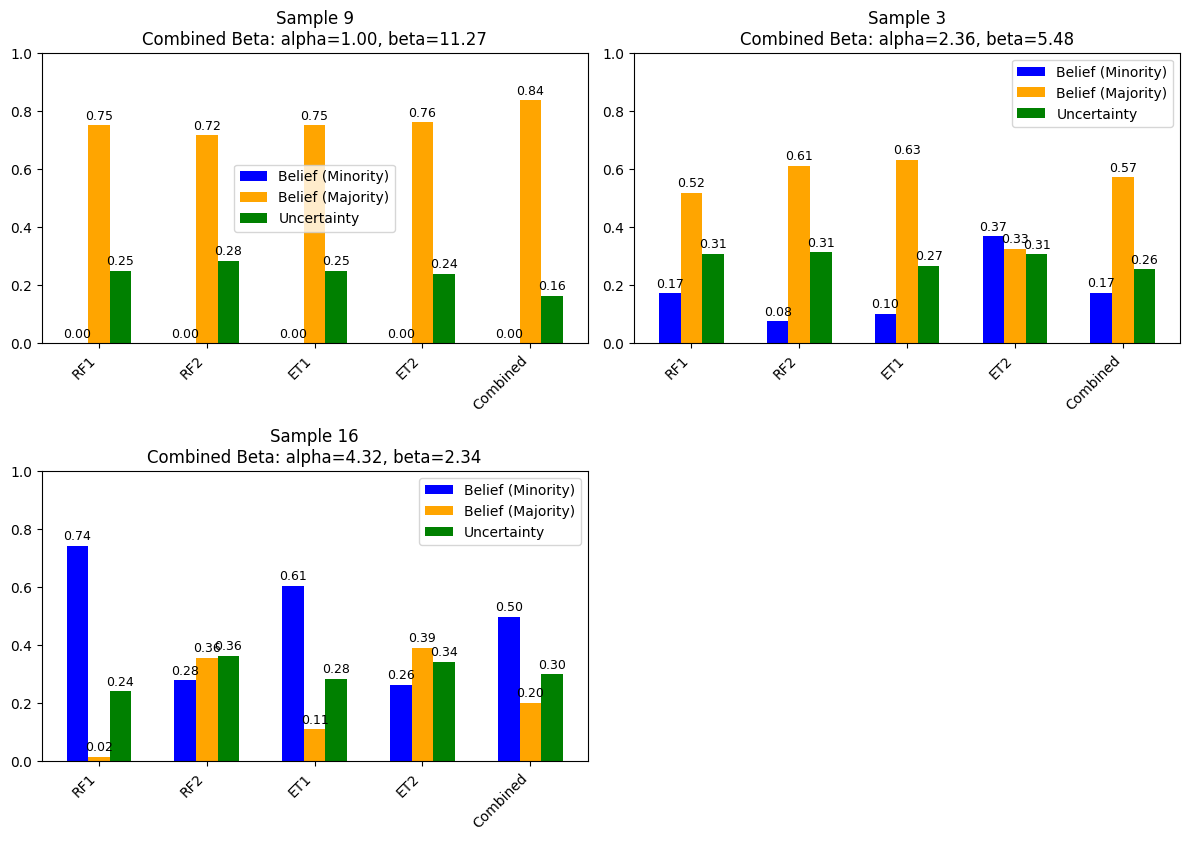

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.special import gammaln, digamma

# 定义 KL 散度函数（根据图片公式）
def KL_divergence(alpha1, beta1, alpha2, beta2):
    """
    计算 Beta 分布的 KL 散度 D_KL(Beta(alpha1, beta1) || Beta(alpha2, beta2))
    """
    term1 = gammaln(alpha2 + beta2) - gammaln(alpha2) - gammaln(beta2)
    term2 = gammaln(alpha1 + beta1) - gammaln(alpha1) - gammaln(beta1)
    term3 = (alpha1 - alpha2) * (digamma(alpha1) - digamma(alpha1 + beta1))
    term4 = (beta1 - beta2) * (digamma(beta1) - digamma(alpha1 + beta1))
    KL = term1 - term2 + term3 + term4
    return KL

def JS_divergence(alpha_combined, beta_combined, alpha_i, beta_i):
    """
    计算 Beta 分布的 JS 散度
    D_JS = 0.5 * D_KL(P || M) + 0.5 * D_KL(Q || M)
    """
    # 平均分布 M 的参数
    alpha_m = 0.5 * (alpha_combined + alpha_i)
    beta_m = 0.5 * (beta_combined + beta_i)
    
    # 计算 KL 散度的两部分
    KL_P_M = KL_divergence(alpha_combined, beta_combined, alpha_m, beta_m)
    KL_Q_M = KL_divergence(alpha_i, beta_i, alpha_m, beta_m)
    
    # 计算 JS 散度
    JS = 0.5 * KL_P_M + 0.5 * KL_Q_M
    
    # 打印中间结果
    # print(f"alpha_combined: {alpha_combined}, beta_combined: {beta_combined}")
    # print(f"alpha_i: {alpha_i}, beta_i: {beta_i}")
    # print(f"alpha_m: {alpha_m}, beta_m: {beta_m}")
    # print(f"KL(P || M): {KL_P_M}, KL(Q || M): {KL_Q_M}")
    print(f"JS Divergence: {JS}")
    
    return JS

def combine_opinions(opinion_1, opinion_2):
    b_i, d_i, u_i = opinion_1
    b_j, d_j, u_j = opinion_2
    C = b_i * d_j + b_j * d_i
    b_combined = (b_i * b_j + b_i * u_j + b_j * u_i) / (1 - C)
    d_combined = (d_i * d_j + d_i * u_j + d_j * u_i) / (1 - C)
    u_combined = (u_i * u_j) / (1 - C)
    b_combined = b_combined / (b_combined + d_combined + u_combined)
    d_combined = d_combined / (b_combined + d_combined + u_combined)
    u_combined = u_combined / (b_combined + d_combined + u_combined)
    return b_combined, d_combined, u_combined

# 定义观点合并函数
def combine_opinions2(opinion_1, opinion_2):
    b_i, d_i, u_i = opinion_1
    b_j, d_j, u_j = opinion_2

    e1 = np.array([b_i, d_i, u_i])
    e2 = np.array([b_j, d_j, u_j])

    elementwise_product = e1 * e2
    C = np.sum(elementwise_product)

    fused_opinion = (1 / C) * elementwise_product + (e1 + e2)
    fused_opinion /= np.sum(fused_opinion)

    return tuple(fused_opinion)

# 生成数据集
X, y = make_moons(n_samples=40, noise=0.3, random_state=36)
minority_class_samples = X[y == 1]
majority_class_samples = X[y == 0]
minority_class_samples = minority_class_samples[:10]
X = np.vstack([majority_class_samples, minority_class_samples])
y = np.hstack([np.zeros(len(majority_class_samples)), np.ones(len(minority_class_samples))])
special_indices = [9, 3, 16]

# 创建分类器
clf1 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf3 = RandomForestClassifier(n_estimators=50, n_jobs=-1)
clf4 = RandomForestClassifier(n_estimators=50, n_jobs=-1)

# 下采样
rus = RandomUnderSampler()
X_resampled_1, y_resampled_1 = rus.fit_resample(X, y)
X_resampled_2, y_resampled_2 = rus.fit_resample(X, y)
X_resampled_3, y_resampled_3 = rus.fit_resample(X, y)
X_resampled_4, y_resampled_4 = rus.fit_resample(X, y)

# 训练分类器
clf1.fit(X_resampled_1, y_resampled_1)
clf2.fit(X_resampled_2, y_resampled_2)
clf3.fit(X_resampled_3, y_resampled_3)
clf4.fit(X_resampled_4, y_resampled_4)

# 收集分类器的预测证据
results = []
for model_name, model in zip(['RF1', 'RF2', 'ET1', 'ET2'], [clf1, clf2, clf3, clf4]):
    for sample_idx in special_indices:
        sample = X[sample_idx].reshape(1, -1)
        total_samples_per_class = np.zeros(model.n_classes_)
        for tree in model.estimators_:
            leaf_index = tree.apply(sample)[0]
            tree_structure = tree.tree_
            samples_per_class = tree_structure.value[leaf_index, 0]
            total_samples_per_class += samples_per_class
        results.append({
            'Model': model_name,
            'Sample Index': sample_idx,
            'Class 0 Evidence': total_samples_per_class[0] / 50,
            'Class 1 Evidence': total_samples_per_class[1] / 50
        })

W = 1  # 权重
opinions = {}
for sample_idx in special_indices:
    sample_opinions = []
    for model_name in ['RF1', 'RF2', 'ET1', 'ET2']:
        result = next(r for r in results if r['Model'] == model_name and r['Sample Index'] == sample_idx)
        E_min = result['Class 1 Evidence']
        E_maj = result['Class 0 Evidence']
        denominator = E_min + E_maj + 2 * W
        belief_min = E_min / denominator
        belief_maj = E_maj / denominator
        uncertainty = 2 * W / denominator
        sample_opinions.append((belief_min, belief_maj, uncertainty))
    opinions[sample_idx] = sample_opinions

# 合并观点
combined_opinions = {}
for sample_idx, sample_opinions in opinions.items():
    combined_opinion = sample_opinions[0]
    for opinion in sample_opinions[1:]:
        combined_opinion = combine_opinions2(combined_opinion, opinion)
    combined_opinions[sample_idx] = combined_opinion

# 定义 Beta 分布参数字典
beta_distributions = {}
combined_beta_distributions = {}

# 单个观点的 Beta 分布计算
for sample_idx in special_indices:
    sample_beta_distributions = []
    for model_name in ['RF1', 'RF2', 'ET1', 'ET2']:
        result = next(r for r in results if r['Model'] == model_name and r['Sample Index'] == sample_idx)
        E_min = result['Class 1 Evidence']
        E_maj = result['Class 0 Evidence']
        alpha = E_min + W
        beta = E_maj + W
        sample_beta_distributions.append((alpha, beta))
    beta_distributions[sample_idx] = sample_beta_distributions

# 综合观点的 Beta 分布计算
for sample_idx, combined_opinion in combined_opinions.items():
    b_s, d_s, u_s = combined_opinion
    alpha_s = (b_s * 2 * W) / u_s + W
    beta_s = (d_s * 2 * W) / u_s + W
    combined_beta_distributions[sample_idx] = (alpha_s, beta_s)

# 计算 KL 散度
KL_results = {}
for sample_idx in special_indices:
    alpha_combined, beta_combined = combined_beta_distributions[sample_idx]
    KL_sample = []
    for alpha_i, beta_i in beta_distributions[sample_idx]:
        KL_sample.append(JS_divergence(alpha_combined, beta_combined, alpha_i, beta_i))
    KL_results[sample_idx] = KL_sample

# 打印每个实例的 JS 散度结果，并计算平均 JS 散度
for sample_idx in special_indices:
    print(f"Sample {sample_idx}:")
    
    # 获取当前实例的 JS 散度结果
    instance_js_values = KL_results[sample_idx]
    
    # 遍历每个模型的 JS 散度
    for model_name, JS_value in zip(['RF1', 'RF2', 'ET1', 'ET2'], instance_js_values):
        print(f"  {model_name} JS Divergence: {JS_value:.4f}")
    
    # 计算并打印当前实例的平均 JS 散度
    average_js = sum(instance_js_values) / len(instance_js_values)
    print(f"  Average JS Divergence: {average_js:.4f}")


# 可视化
fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=100)
axes = axes.flatten()

for i, sample_idx in enumerate(special_indices):
    single_opinions = opinions[sample_idx]
    combined = combined_opinions[sample_idx]
    x = ['RF1', 'RF2', 'ET1', 'ET2', 'Combined']
    beliefs_minority = [o[0] for o in single_opinions] + [combined[0]]
    beliefs_majority = [o[1] for o in single_opinions] + [combined[1]]
    uncertainties = [o[2] for o in single_opinions] + [combined[2]]
    
    ax = axes[i]
    ax.set_ylim(0, 1)
    bar_width = 0.2
    bars_min = ax.bar(np.arange(len(x)) - bar_width, beliefs_minority, bar_width, label='Belief (Minority)', color='blue')
    bars_maj = ax.bar(np.arange(len(x)), beliefs_majority, bar_width, label='Belief (Majority)', color='orange')
    bars_unc = ax.bar(np.arange(len(x)) + bar_width, uncertainties, bar_width, label='Uncertainty', color='green')
    
    for bar in bars_min:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_maj:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    for bar in bars_unc:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_title(f"Sample {sample_idx}\nCombined Beta: alpha={combined_beta_distributions[sample_idx][0]:.2f}, beta={combined_beta_distributions[sample_idx][1]:.2f}")
    ax.legend()

# 删除多余子图
for i in range(len(special_indices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


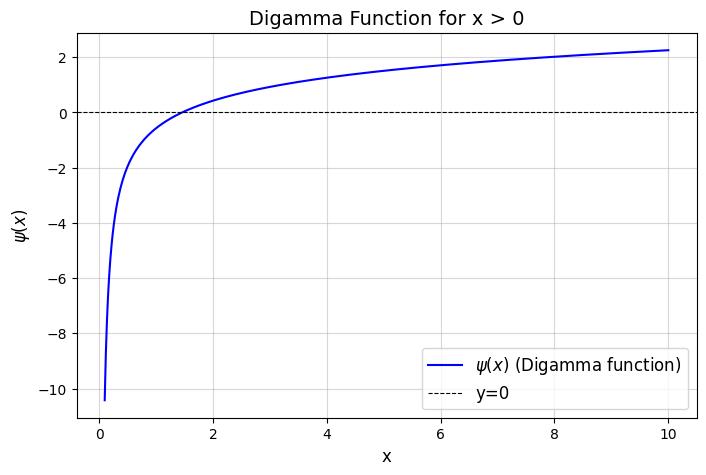

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import digamma

# 生成 x > 0 的值
x = np.linspace(0.1, 10, 500)  # 避免 x=0，设置最小值为 0.1
y = digamma(x)  # 计算 digamma 函数值

# 绘制 digamma 函数图像
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r'$\psi(x)$ (Digamma function)', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label='y=0')
plt.title("Digamma Function for x > 0", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel(r'$\psi(x)$', fontsize=12)
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.show()
